### Downstream Analysis 2
In this notebook, we will focus on the downstream analysis from a more macro scale. We will combine all CRE (regions) and look at all of them together. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pickle
from scipy.stats import spearmanr, pearsonr
import warnings
from tqdm import tqdm

In [4]:
def array_stats(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    arr_mean = np.mean(arr)
    arr_median = np.median(arr)
    arr_std = np.std(arr)
    arr_variance = np.var(arr)
    arr_length = len(arr)
    print("Minimum: ", arr_min)
    print("Maximum: ", arr_max)
    print("Mean: ", arr_mean)
    print("Median: ", arr_median)
    print("Standard Deviation: ", arr_std)
    print("Variance: ", arr_variance)
    print("Length: ", arr_length)

In [2]:
colors = {'0': '#000000',
             '1': '#010067',
             '2': '#D5FF00',
             '3': '#FF0056',
             '4': '#9E008E',
             '5': '#0E4CA1',
             '6': '#FFE502',
             '7': '#005F39',
             '8': '#00FF00',
             '9': '#95003A',
             '10': '#FF937E',
             '11': '#A42400',
             '12': '#001544',
             '13': '#91D0CB',
             '14': '#620E00',
             '15': '#6B6882',
             '16': '#0000FF',
             '17': '#007DB5',
             '18': '#6A826C',
             '19': '#00AE7E',
             '20': '#C28C9F',
             '21': '#BE9970',
             '22': '#008F9C',
             '23': '#5FAD4E',
             '24': '#FF0000',
             '25': '#FF00F6',
             '26': '#FF029D',
             '27': '#683D3B',
             '28': '#FF74A3',
             '29': '#968AE8',
             '30': '#98FF52',
             '31': '#A75740',
             '32': '#01FFFE',
             '33': '#FFEEE8',
             '34': '#FE8900',
             '35': '#BDC6FF',
             '36': '#01D0FF',
             '37': '#BB8800',
             '38': '#7544B1',
             '39': '#A5FFD2',
             '40': '#FFA6FE',
             '41': '#774D00',
             '42': '#7A4782',
             '43': '#263400',
             '44': '#004754',
             '45': '#43002C',
             '46': '#B500FF',
             '47': '#FFB167',
             '48': '#FFDB66',
             '49': '#90FB92',
             '50': '#7E2DD2',
             '51': '#BDD393',
             '52': '#E56FFE',
             '53': '#DEFF74',
             '54': '#00FF78',
             '55': '#009BFF',
             '56': '#006401',
             '57': '#0076FF',
             '58': '#85A900',
             '59': '#00B917',
             '60': '#788231',
             '61': '#00FFC6',
             '62': '#FF6E41',
             '-1': '#000000'}

In [33]:
# # Load the .npy file
# data = np.load('/data/peer/panb2/replicate/result_tensor.npy')
# print(data.shape)

# # the dimension of the region is not important, so we remove it to faciliate later analysis
# concatenated_data = np.concatenate(data, axis=1)
# print(concatenated_data.shape)

# np.save('/data/peer/panb2/replicate/concatenated_result_tensor.npy', concatenated_data)

(359263, 25, 501)


In [38]:
concatenated_data = np.load('/data/peer/panb2/replicate/concatenated_result_tensor.npy')

In [86]:
concatenated_data.shape

(25, 179990763)

#### Perform preprocessing on the data
We first remove all the columns that sum to 0. These columns don't provide us with any valuable information regarding how cell clusters are different from each other.

In [87]:
# Initialize a list to store valid column indices
valid_column_indices = []

# Iterate over each column index
for i in range(concatenated_data.shape[1]):
    # Extract the column
    column = concatenated_data[:, i]
    
    # Check if the column sum is 0 or contains NaN values
    if np.sum(column) != 0 and np.sum(column) != np.inf:
        # If the column is valid, add its index to the list
        valid_column_indices.append(i)

# Create a new array containing only the valid columns
filtered_data = concatenated_data[:, valid_column_indices]

In [88]:
filtered_data.shape

(25, 174884318)

174884335 columns were left after removing columns with sum of 0. 
174884318 columns were left after furthur removing columns that sums up to inf. 

In [89]:
# making sure that the largest element is no longer infinity
largest_element = np.max(filtered_data)
print(largest_element)

289.913888276746


In [92]:
np.save('/data/peer/panb2/replicate/filtered_concatenated_result_tensor.npy', filtered_data)

In [4]:
filtered_data = np.load('/data/peer/panb2/replicate/filtered_concatenated_result_tensor.npy')

#### Perform PCA on a subset of the data

In [5]:
# 'data' is the array of size (25, 174884318)

# Take a random subset of data
subset_size = 174884318
random_indices = np.random.choice(filtered_data.shape[1], size=subset_size, replace=False)

data_subset = filtered_data#[:, random_indices]

# Perform PCA
n_components = 25  # Choose the number of principal components
pca = PCA(n_components=n_components)
pca.fit(data_subset)

# Transform the data using the learned PCA model
transformed_data = pca.transform(data_subset)
np.save('transformed_data_2.npy', transformed_data)

In [6]:
transformed_data.shape

(25, 25)

In [3]:
transformed_data = np.load('transformed_data_2.npy')

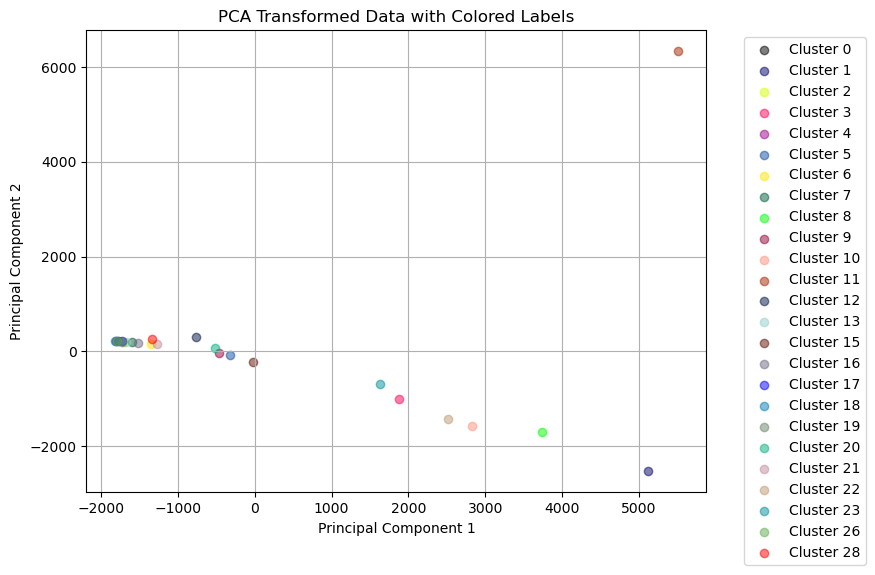

In [4]:
# Create labels for each data point
original_clusters = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,26,28]
labels = [f'Cluster {i}' for i in original_clusters]

# Create a scatter plot of the transformed data with colored labels
plt.figure(figsize=(8, 6))
for i in range(transformed_data.shape[0]):
    plt.scatter(transformed_data[i, 0], transformed_data[i, 1], color=[colors[str(i)]], alpha=0.5, label=labels[i])

plt.title('PCA Transformed Data with Colored Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Feature Selection: Examine which CRE contributes to the correlation with PC1
First load the relevant numpy arrays

In [7]:
filtered_data = np.load('/data/peer/panb2/replicate/filtered_concatenated_result_tensor.npy')
filtered_data.shape

(25, 174884318)

In [8]:
transformed_data = np.load('transformed_data_2.npy')
transformed_data.shape

(25, 25)

In [9]:
# extracting the first principle component
pc1 = transformed_data[:,0]
pc1

array([-1776.03160405,  5113.13641059, -1705.2421875 ,  1875.4731345 ,
       -1804.27766616,  -326.90456065, -1349.51725793, -1600.76801955,
        3742.5016668 ,  -463.76532787,  2820.39029319,  5508.6286909 ,
        -766.86782964, -1673.31864632,   -27.14293585, -1518.26323506,
       -1723.93632789, -1822.91907442, -1732.18919954,  -513.34666809,
       -1268.75903735,  2515.61111491,  1624.0219051 , -1796.06706955,
       -1330.44656857])

We realized that the clusters with the two largest values of PC1 are Cluster 1 and Cluster 11. (not Cluster 11 and 12 as previously believed).

We now calculate the correlation coefficients of PC1 with each of the 174884318 features in the filtered_data

In [33]:
# filtered_data = np.random.rand(25,1000)

In [ ]:
# Pre-allocate NumPy arrays for the Spearman and Pearson coefficients
pearson_coeff_array = np.empty(filtered_data.shape[1])

total_iterations = filtered_data.shape[1]
progress_bar = tqdm(total=total_iterations, desc="Processing")

for i in range(total_iterations):
    pearson_coeff_array[i] = pearsonr(pc1, filtered_data[:,i])[0]
    progress_bar.update(1)

progress_bar.close()
print("Task completed!")
print(pearson_coeff_array.shape)

np.save('/data/peer/panb2/replicate/pearson_coeff_array.npy', pearson_coeff_array)

Processing:   0%|          | 590187/174884318 [08:02<41:44:56, 1159.67it/s]

In [ ]:
# Pre-allocate NumPy arrays for the Spearman and Pearson coefficients
spearman_coeff_array = np.empty(filtered_data.shape[1])

total_iterations = filtered_data.shape[1]
progress_bar = tqdm(total=total_iterations, desc="Processing")

# We still need a loop for Spearman since it involves ranking
for i in range(total_iterations):
    spearman_coeff_array[i] = spearmanr(pc1, filtered_data[:, i])[0]
    progress_bar.update(1)

progress_bar.close()
print("Task completed!")
print(spearman_coeff_array.shape)

np.save('/data/peer/panb2/replicate/spearman_coeff_array.npy', spearman_coeff_array)

Processing:  14%|█▍        | 24990824/174884318 [2:02:04<12:07:28, 3434.08it/s]

The next step is to find the CRE's with very positive or very negative correlation coefficients, and plot the nucleosome position changes across clusters.